# This notebook is a scratch pad to develop the model 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming
import scipy.stats as ss

import sys

sys.path.append("../") 
import doe_utils


# TEST MAKE AMINO ACID WORLD SMALL 

AMINO_ACIDS = doe_utils.AMINO_ACIDS

# For simulation, create a random parent amino acid sequence to create SOLD libraries from

In [2]:
length_of_protein = 100
parent = ''.join(np.random.choice(AMINO_ACIDS, length_of_protein))
print("Parent protein:", parent) 

Parent protein: QTQIIMESPGDFDCSYQKFGTCHFTPYRADEIMWICFILNRPKGTSKAPLMMIGSAAFTNPGCHTWEQGGRGVRCWIAIIFQGCYGHDNKCYMHLWFCLE


# Need to create a matrix of postion vs letters

In [3]:
num_mutated = 6
mutated_pos = np.sort(np.random.choice(range(length_of_protein), num_mutated, replace = False))
print(mutated_pos) 

[ 0 60 63 67 74 94]


## For every poisiton to mutate choose a few amino acids to mutate to, with parent amino acid at that pos. to be most probable 

In [4]:
random_muts = [] 
parent_prob = 0.85
mut_probs = [0.05, 0.05, 0.05] # I am keeping it simple here 
assert np.sum(mut_probs) + parent_prob == 1

mut_dict = defaultdict(dict) 
for i in mutated_pos: 
    draws = list(AMINO_ACIDS) 
    draws.remove(parent[i]) 
    to_draw = np.random.choice(draws, len(mut_probs), replace = False) 
    mut_dict[int(i)] = {parent[i]: parent_prob} 
    for k,l in enumerate(to_draw):
        mut_dict[int(i)].update({str(l): mut_probs[k]})

In [5]:
# Create mutation matrix 
sold_mat = np.zeros((len(AMINO_ACIDS), length_of_protein))
for k,v in mut_dict.items(): 
    for base, prob in v.items(): 
        sold_mat[AMINO_ACIDS.index(base), k] = prob


sold_mat_df = pd.DataFrame(sold_mat, index = AMINO_ACIDS, columns = np.arange(length_of_protein))
sold_mat_df.head() 

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plot the SOLD matrix 

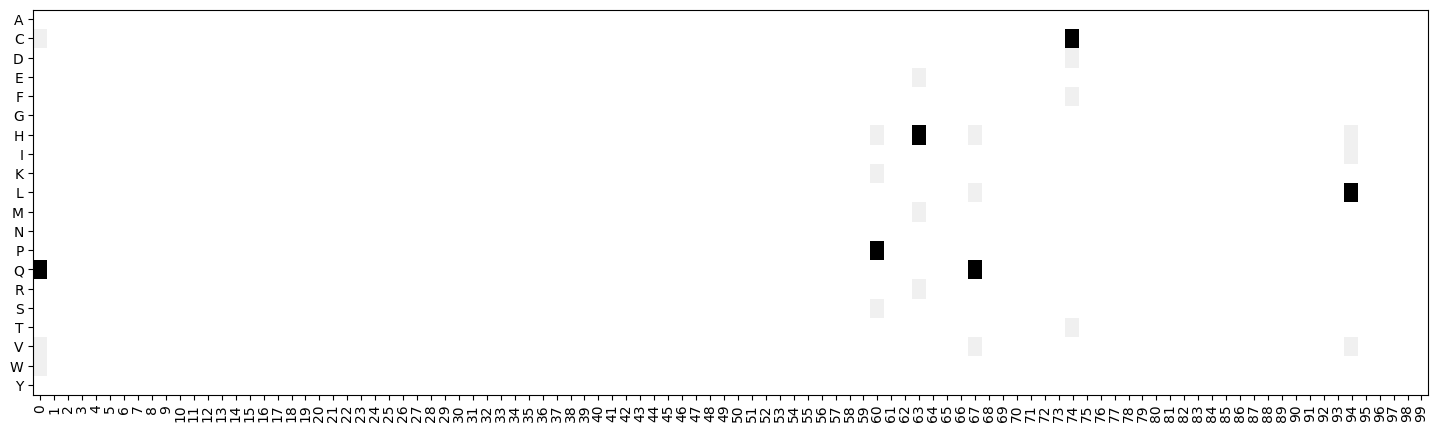

In [6]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)


# Now let's try to draw mutated sequences from this matrix 
## Above I have created a simple SOLD mat, but I want to make tools such that everything below will work with any experimentaliat provided SOLD mat

In [7]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(1000)

In [8]:
seqs[0]

'QPHQCL'

In [9]:
a= S.compute_prob_n_mutations(num_mutated)

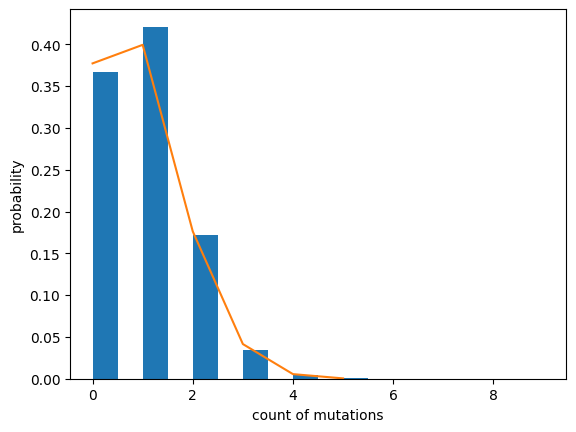

In [10]:
plt.hist(mutations, bins= np.array(range(10)), density = True, align = "mid", width = 0.5) 
plt.ylabel('probability')
plt.xlabel('count of mutations') 
plt.plot(a)

# Test encoding  

In [11]:
# Given a mutational landscape defined by a SOLD matric we want to create a simulator that assigns individual, 
# epistatic and effects 

In [12]:
# Run SOLD mat through the class to get the positions mutated and what muations can be observed 
S.mutation_probs_variable_region_indexed

defaultdict(None,
            {0: {'C': 0.05, 'Q': 0.85, 'V': 0.05, 'W': 0.05},
             1: {'H': 0.05, 'K': 0.05, 'P': 0.85, 'S': 0.05},
             2: {'E': 0.05, 'H': 0.85, 'M': 0.05, 'R': 0.05},
             3: {'H': 0.05, 'L': 0.05, 'Q': 0.85, 'V': 0.05},
             4: {'C': 0.85, 'D': 0.05, 'F': 0.05, 'T': 0.05},
             5: {'H': 0.05, 'I': 0.05, 'L': 0.85, 'V': 0.05}})

In [13]:
S.mutation_probs


defaultdict(dict,
            {0: {'C': 0.05, 'Q': 0.85, 'V': 0.05, 'W': 0.05},
             60: {'H': 0.05, 'K': 0.05, 'P': 0.85, 'S': 0.05},
             63: {'E': 0.05, 'H': 0.85, 'M': 0.05, 'R': 0.05},
             67: {'H': 0.05, 'L': 0.05, 'Q': 0.85, 'V': 0.05},
             74: {'C': 0.85, 'D': 0.05, 'F': 0.05, 'T': 0.05},
             94: {'H': 0.05, 'I': 0.05, 'L': 0.85, 'V': 0.05}})

# Create a mixture of weigthts with random components and some sparse components 

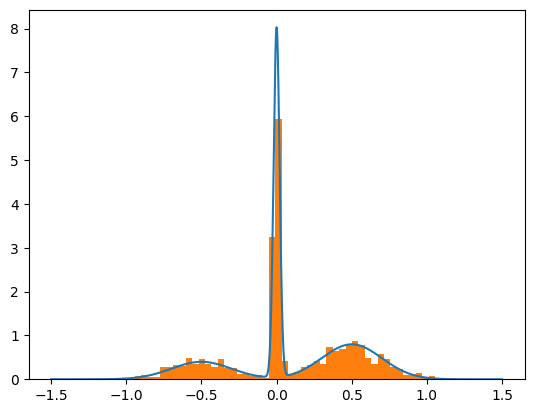

In [14]:
# Example

G = doe_utils.create_mixture()
samples, index = G.samples(1000)
x = np.linspace(-1.5, 1.5, 10000)

plt.plot(x, G.pdf()(x))
_ = plt.hist(samples, density=True, bins = 50)

In [15]:
Model1 = doe_utils.create_in_silico_model(num_mutated)

In [16]:
Encoder = doe_utils.sequence_encoder(num_mutated)
res = Encoder.encode_seqs(seqs)

In [17]:
response = Model1.model(res[0], res[1]) 

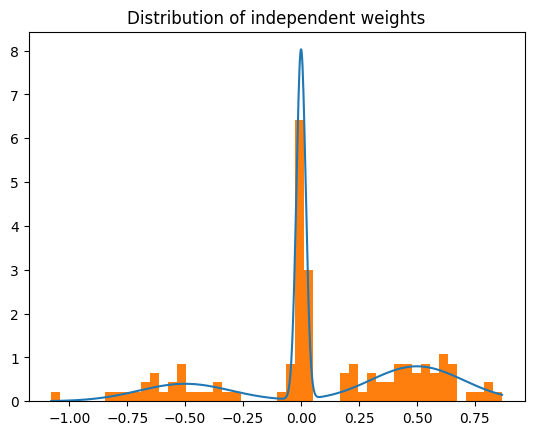

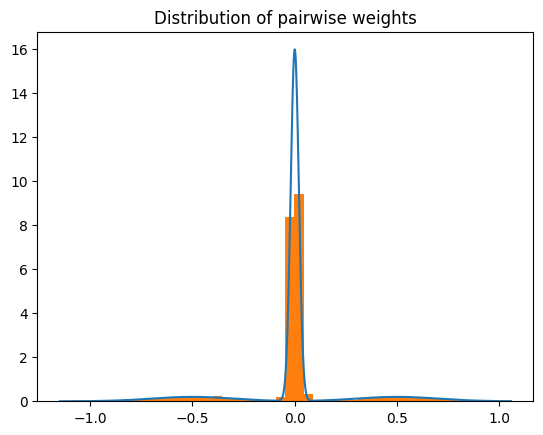

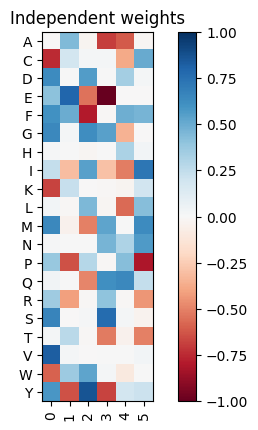

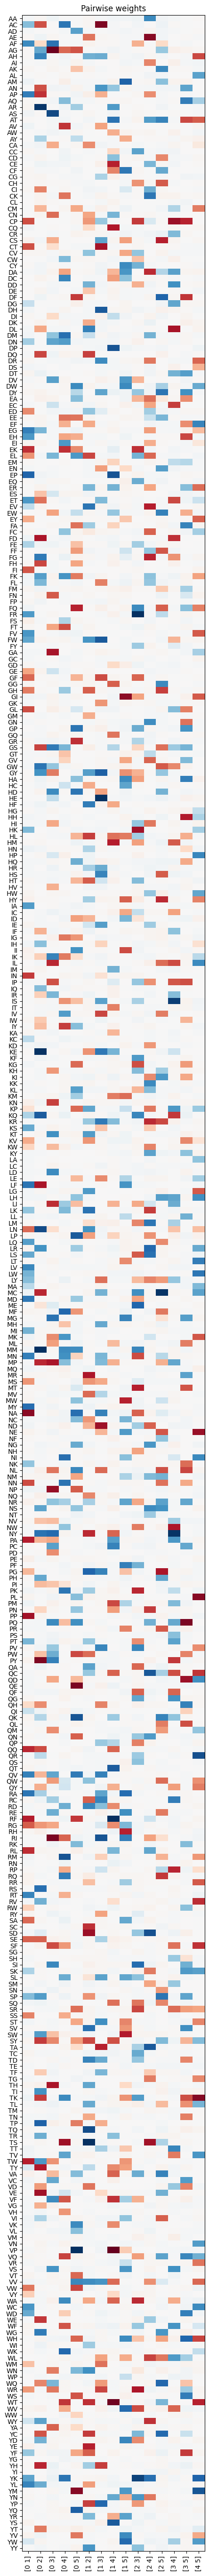

In [18]:
Model1.plot_weights()

In [29]:
independent_mask, pairwise_mask = Model1.create_masked_weights(S.mutation_probs_variable_region_indexed)

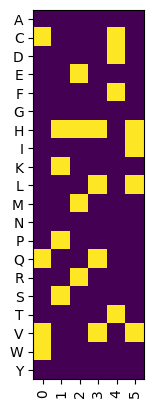

In [30]:
plt.imshow(independent_mask) 
_  = plt.xticks(range(mutated_region_length), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)

Text(0.5, 1.0, 'Pairwise weights')

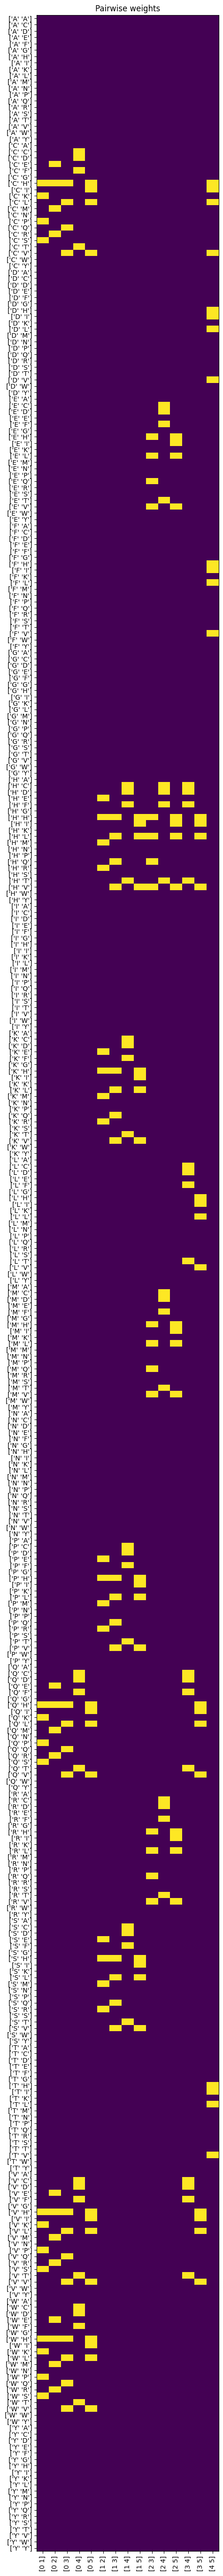

In [31]:
plt.figure(figsize = (5, 70))
plt.imshow(pairwise_mask,  aspect = 'auto') 
_  = plt.xticks(range(len(pos_product)), S.pos_product, rotation = 90)
_  = plt.yticks(range(len(amino_product)), amino_product)
plt.title("Pairwise weights") 